In [67]:
import random
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Пример переобучения

Подготовим данные для демонстрации переобучения на них. Сгенерируем тренировочную и тестовую выборку с помощью линейной функции с нормальным шумом. 

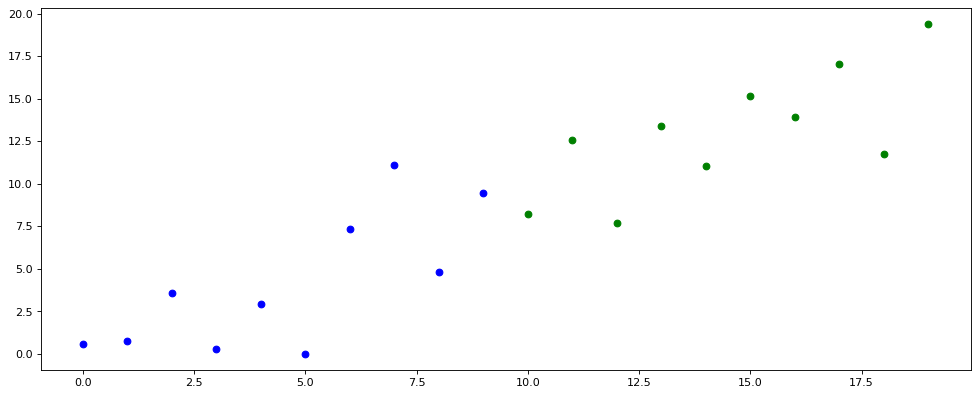

In [68]:
plt.figure(figsize=(15, 6), dpi=80)

# параметры выборки - размер и дисперсия шума
TRAIN_SET = 10
TEST_SET = 10
VARIANCE = 0.5

#генерация тренировочной выборки
x_train = np.array([i for i in range(TRAIN_SET)])
y_train = np.array([(x + 5 * np.random.normal(0,VARIANCE)) for x in x_train])

#генерация тестовой выборки
x_test = np.array([i for i in range(TRAIN_SET,TRAIN_SET + TEST_SET)])
y_test = np.array([(x + 5 * np.random.normal(0,VARIANCE)) for x in x_test])

plt.scatter(x_train, y_train, color='b')
plt.scatter(x_test, y_test, color='g')

In [69]:
def poly_experiment_train(X_train, Y_train, nb_degree, model):
    """
    функция обучения для полиномиальной регрессии
    """
    # преобразование независимой переменной в количество признаков равному степени полинома
    polynomial_features = PolynomialFeatures(degree = nb_degree)
    X_TRANSF = polynomial_features.fit_transform(X_train.reshape(-1,1))
    #обучение линейной регрессии
    model.fit(X_TRANSF, Y_train)
    #оценка на обучающей выборке
    Y_NEW = model.predict(X_TRANSF)
    mse = mean_squared_error(Y_train, Y_NEW)
    return {"transformer": polynomial_features,
            "model": model,
            "prediction": Y_NEW,
            'error': mse}

def poly_experiment_test(X_test, Y_test, transformer, model):
    """
    функция предсказания на тестовой выборке. На вход обученный преобразователь в полином(transformer)
    и модель с подобранными весами.
    """
    X_TRANSF = transformer.transform(X_test.reshape(-1,1))
    Y_NEW = model.predict(X_TRANSF)
    mse = mean_squared_error(Y_test, Y_NEW)
    return {"prediction": Y_NEW, 'error': mse}

(-10.0, 29.370233853903766)

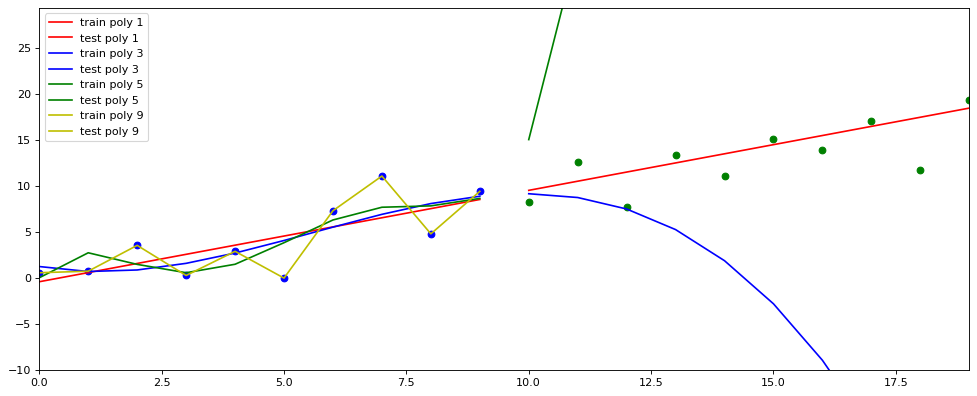

In [70]:
plt.figure(figsize=(15, 6), dpi=80)


models_coefs = []

test_mse_list = []

# рассмотрим полиномы соответсвующих степеней и определим цвета их графиков
degree_dict = {
    1: 'r',
    3: 'b',
    5: 'g',
    9: 'y',
}
for degree in degree_dict:
    # инициализируем модель
    model = LinearRegression()
    # предсказания на обучающей выборке
    train_pred = poly_experiment_train(x_train, y_train, degree, model)
    plt.plot(x_train, train_pred['prediction'], label = f'train poly {degree}', color=degree_dict[degree])
    
    #предсказания на тестовой выборке
    test_pred = poly_experiment_test(x_test, y_test, train_pred['transformer'], train_pred['model'])
    plt.plot(x_test, test_pred['prediction'], label = f'test poly {degree}', color=degree_dict[degree])
    
    test_mse_list.append(test_pred['error'])
    models_coefs.append(train_pred['model'].coef_)
    
    
# визуализация обучения
plt.legend(loc='best')

plt.scatter(x_train, y_train, color='b')
plt.scatter(x_test, y_test, color='g')

plt.xlim(x_train[0], x_test[-1])
plt.ylim(np.min(x_train) - 10, np.max(y_test) + 10) 

In [71]:
# выведем ошибки полиномов на тестовой выборке
for key, error in zip(list(degree_dict.keys()), test_mse_list):
    print(f"poly {key} - {error}")

poly 1 - 6.417675085926474
poly 3 - 682.5201449916682
poly 5 - 2642499.7146066874
poly 9 - 252111478409165.9


In [72]:
#посмотрим на коэфициенты обученных моделей
for key, coefs in zip(list(degree_dict.keys()), models_coefs):
    print(f"poly {key} :", coefs)
    print()

poly 1 : [0.         0.99282556]

poly 3 : [ 0.         -0.94526414  0.43082119 -0.02572017]

poly 5 : [ 0.          7.05256108 -5.86710117  1.72061726 -0.20058882  0.00816465]

poly 9 : [ 0.00000000e+00 -1.92330289e+02  4.86327900e+02 -4.77672501e+02
  2.45133288e+02 -7.30905313e+01  1.31124262e+01 -1.39383215e+00
  8.08066424e-02 -1.96714461e-03]



#### Regularization

Воспользуемся регрессиями с регуляризацией - Lasso и Ridge. Посмотрим, как в обоих случаях влияет регуляризация на ошибку на тестовой выборке. 

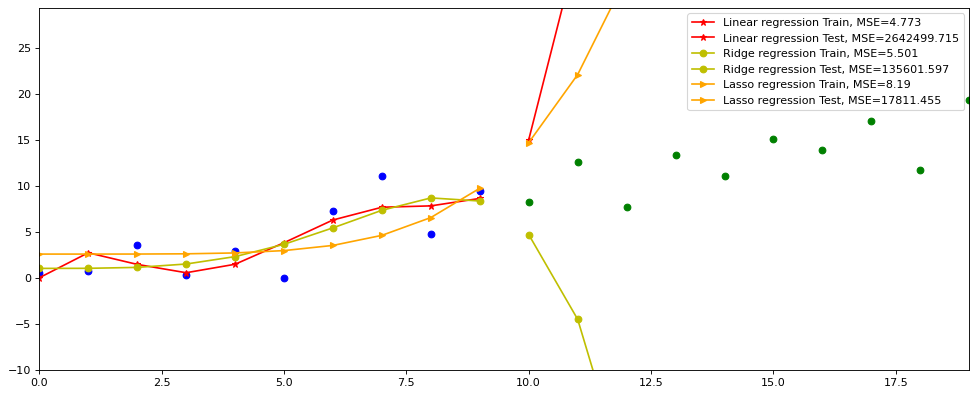

In [73]:
#linear regression
plt.figure(figsize=(15, 6), dpi=80)
plt.scatter(x_train, y_train, color='b')
plt.scatter(x_test, y_test, color='g')

# для моделирования возьмем полином 4 степени
DEGREE = 5
# коэфициент регуляризации
ALPHA_SIZE = 5000

#обучим обычную линейную регрессию и версии с регуляризацией


lin_model = LinearRegression()
lin_train = poly_experiment_train(x_train, y_train, DEGREE, lin_model)
plt.plot(x_train, lin_train['prediction'], '*-', label = f"Linear regression Train, MSE={round(lin_train['error'], 3)}", color='r')

lin_test = poly_experiment_test(x_test, y_test, lin_train['transformer'], lin_train['model'])
plt.plot(x_test, lin_test['prediction'], '*-', label = f"Linear regression Test, MSE={round(lin_test['error'], 3)}", color='r')

ridge_model = Ridge(alpha=ALPHA_SIZE)
ridge_train = poly_experiment_train(x_train, y_train, DEGREE, ridge_model)
plt.plot(x_train, ridge_train['prediction'], 'o-' ,label = f"Ridge regression Train, MSE={round(ridge_train['error'], 3)}", color='y')

ridge_test = poly_experiment_test(x_test, y_test, ridge_train['transformer'], ridge_train['model'])
plt.plot(x_test, ridge_test['prediction'], 'o-', label = f"Ridge regression Test, MSE={round(ridge_test['error'], 3)}", color='y')

lasso_model = Lasso(alpha=ALPHA_SIZE)
lasso_train = poly_experiment_train(x_train, y_train, DEGREE, lasso_model)
plt.plot(x_train, lasso_train['prediction'], '>-', label = f"Lasso regression Train, MSE={round(lasso_train['error'], 3)}", color='orange')

lasso_test = poly_experiment_test(x_test, y_test, lasso_train['transformer'], lasso_train['model'])
plt.plot(x_test, lasso_test['prediction'], '>-' ,label = f"Lasso regression Test, MSE={round(lasso_test['error'], 3)}", color='orange')

#посмотрим на графике, как меняется предсказание на тестовой выборке в зависимости от типа модели

plt.legend(loc='best')
plt.xlim(x_train[0], x_test[-1])
plt.ylim(np.min(x_train) - 10, np.max(y_test) + 10) 

plt.savefig('regularization_example.png')

/var/folders/hg/wyjbzhnn71d60tgsx5l8yt1c0000gn/T/ipykernel_76993/1456326039.py:20: RuntimeWarning: divide by zero encountered in log
  ax1.plot(np.log(ALPHA_LIST), coefs_list)
/var/folders/hg/wyjbzhnn71d60tgsx5l8yt1c0000gn/T/ipykernel_76993/1456326039.py:25: RuntimeWarning: divide by zero encountered in log
  ax2.plot(np.log(ALPHA_LIST), error_list)


Text(0.5, 1.0, 'Влияние регуляризации на ошибку модели')

<Figure size 1200x480 with 0 Axes>

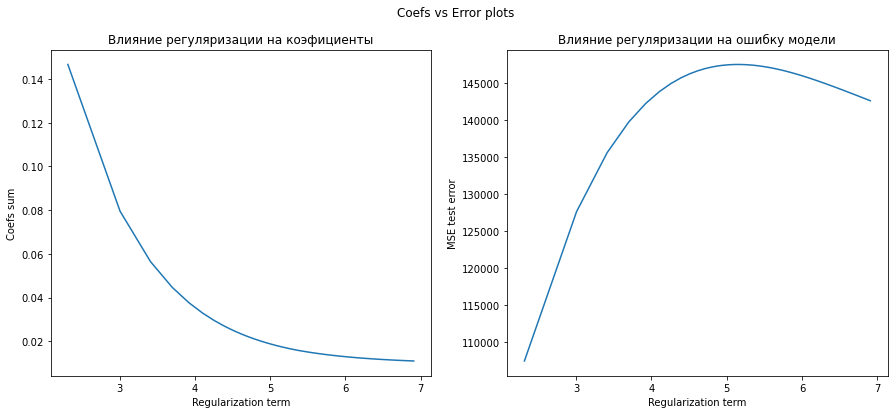

In [74]:
plt.figure(figsize=(15, 6), dpi=80)

ALPHA_LIST = np.linspace(0,1000, 100)

coefs_list, error_list = [], []
#посмотрим на коэффициенты модели и ошибку на тестовой выборке при разных параметрах регуляризации
for alpha in ALPHA_LIST:
    ridge_model = Ridge(alpha=alpha)
    ridge_train = poly_experiment_train(x_train, y_train, DEGREE, ridge_model)
    ridge_test = poly_experiment_test(x_test, y_test, ridge_train['transformer'], ridge_train['model'])
    coefs_list.append(sum(np.abs(ridge_train['model'].coef_)))
    error_list.append(ridge_test['error'])

    
# построим графики зависимости
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

fig.suptitle('Coefs vs Error plots')

ax1.plot(np.log(ALPHA_LIST), coefs_list)
ax1.set_xlabel('Regularization term')
ax1.set_ylabel('Coefs sum')
ax1.set_title('Влияние регуляризации на коэфициенты')

ax2.plot(np.log(ALPHA_LIST), error_list)
ax2.set_xlabel('Regularization term')
ax2.set_ylabel('MSE test error')
ax2.set_title('Влияние регуляризации на ошибку модели')

In [75]:
# найдем коэфициент регуляризации, при котором ошибка на тестовой выборке мнимальна
ALPHA_LIST[np.argmin(error_list)]

10.1010101010101

### Практикум

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [50]:
df = pd.read_csv('house_prices_train.csv')
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [60]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].mean())
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())

In [61]:
num_features = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 
                'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
                '1stFlrSF','2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
                'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 
                'GarageCars', 'GarageArea', 'WoodDeckSF','OpenPorchSF', 
                'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
                'MiscVal', 'MoSold', 'YrSold']

In [62]:
X_train, X_val, y_train, y_val = train_test_split(df[num_features], df['SalePrice'], test_size=0.25, random_state=42)
X_train.shape, X_val.shape

((1095, 32), (365, 32))

In [65]:
X_train_scaled = X_train[num_features].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
X_val_scaled = X_val[num_features].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [66]:
def calculate_significance(y_true, y_preds, coefs_num):
    """
    функция рассчета статистик и коэфициента детерминации
    """
    #don't forget bias
    coefs_num += 1
    
    ss_reg = ((y_true - y_preds) ** 2).sum(axis=0)
    ss_mean = ((y_true - np.average(y_true, axis=0)) ** 2).sum(axis=0)
    r_squared = (ss_mean - ss_reg) / ss_mean
    adj_r_squared = 1 - (len(y_true) - 1)/(len(y_true)- coefs_num - 1)*(1-r_squared)
    
    df1 = (coefs_num - 1)
    df2 = (len(y_true) - coefs_num)

    numerator = r_squared/df1
    denumerator = (1 - r_squared)/df2
    F = numerator / denumerator

    #area to the right in pdf
    p_value = 1 - f.cdf(F, df1, df2)

    return {'p-value': p_value, 'F stat': F, 'r_squared': r_squared, 'adj_r_squared': adj_r_squared}

#### Задание 1 (1 балл)

Воспользуйтесь https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html для обучения Lasso регрессии. При повышении параметра регуляризации, Lasso зануляет менее важные признаки. Сравните, как влияет отбор признаков с помощью Lasso регрессии на коэфициент детерминации модели при изменении количества рабочих признаков на валидационной выборке. Постройте график зависимости $R^2$ от количества признаков.


* Не забудьте заполнить пропуски в данных и предобработать признаки. 

In [ ]:
### CODE HERE

#### Задание 2 (1 балл)

Аналогично обучите Ridge регрессию таким же методом. Подберите на ней параметр регуляризации, при котором MSE ошибка на валидационной выборке минимальна. Для подбора оптимального гиперпараметра, можно воспользоваться кодом с семинара. Визуализируйте график зависимости ошибки от параметра регуляризации и график нормы весов от параметра регуляризации.

In [ ]:
### CODE HERE

#### Задание 3 (1 балл)

Какая модель дает наилучшее качество на нашем датасете на валидационной выборке?

In [ ]:
### CODE HERE